## Homework 5

Adam Grabowski |
CS 541 Deep Learning |
October 15, 2023

In [19]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, RandomSampler, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if GPU available

### Problem 1

In [21]:
class CustomDataset(Dataset):
    def __init__(self, faces, ages, transform=None):
        self.faces = faces # Grayscale face images
        self.ages = ages.reshape(-1, 1) # Reshape ages to column vectors
        self.transform = transform # Data transformation

    def __len__(self):
        return len(self.faces)

    def __getitem__(self, idx):
        image = self.faces[idx] # Get image at specified index
        age = self.ages[idx] # Get age label corresponding to image
        if self.transform:
            image = self.transform(image) # Apply transformation to image
        image = image.float() # Convert image to float tensor
        age = torch.tensor(age, dtype=torch.float32) # Convert age to float tensor
        return image, age

In [22]:
def preprocess_data(faces, ages):
    model = models.vgg16(weights='DEFAULT') # Load VGG16 model with default weights
    model.classifier[-1] = nn.Linear(4096, 1) # Modify output layer to produce single value
    model = model.to(device) # Move model to specified device (e.g., GPU)

    preprocess = transforms.Compose([
        transforms.ToPILImage(), # Convert image to a PIL Image
        transforms.Grayscale(num_output_channels=3), # Convert grayscale to pseudo-RGB
        transforms.Resize((224, 224)), # Resize image to VGG16 input size
        transforms.ToTensor(), # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize image
    ])

    return model, preprocess

In [23]:
def create_datasets(faces, ages, preprocess):
    # Create custom dataset with image preprocessing
    custom_dataset = CustomDataset(faces, ages, transform=preprocess)
    total_samples = len(custom_dataset)

    # Split custom dataset into training and testing sets
    train_val_size = int(0.8 * total_samples)
    test_size = total_samples - train_val_size
    train_val_dataset, test_dataset = random_split(custom_dataset, [train_val_size, test_size])

    # Split training dataset into training and validation sets
    train_size = int(0.8 * train_val_size)
    val_size = train_val_size - train_size
    train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

    return train_dataset, val_dataset, test_dataset

In [24]:
def create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size):
    # Create data loaders for training, validation, and testing sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)

    return train_loader, val_loader, test_loader

In [25]:
def eval_model(model, eval_loader, criterion):
    model.eval()
    with torch.no_grad():
        eval_losses = []
        for inputs, labels in eval_loader: # Iterate over evaluation loader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs) # Forward pass
            eval_loss = criterion(outputs, labels) # Calculate loss
            eval_losses.append(eval_loss.item())

    return eval_losses

In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_epoch):
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad() # Zero gradients
            outputs = model(inputs) # Forward pass
            train_loss = criterion(outputs, labels) # Calculate loss
            train_loss.backward() # Backward pass
            optimizer.step() # Update parameters

        if print_epoch: # Calculate train and validation RMSE for epoch
            train_rmse = np.sqrt(train_loss.item())
            val_losses = eval_model(model, val_loader, criterion)
            val_rmse = np.sqrt(sum(val_losses) / len(val_losses))
            print(f'Epoch {epoch + 1}/{num_epochs}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}')

In [27]:
def find_best_hyperparameters(faces, ages, learning_rates, batch_sizes, num_epochs):
    # Initialize best RMSE and hyperparameters
    best_val_rmse = float('inf')
    best_learning_rate = None
    best_batch_size = None

    # Iterate learning rates and batch sizes
    for learning_rate in learning_rates:
        for batch_size in batch_sizes:
            # Preprocess data and create data loaders
            model, preprocess = preprocess_data(faces, ages)
            train_dataset, val_dataset, test_dataset = create_datasets(faces, ages, preprocess)
            train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, batch_size)

            # Define loss criterion and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Train model and calculate validation RMSE
            train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, False)
            val_losses = eval_model(model, val_loader, criterion)
            val_rmse = np.sqrt(sum(val_losses) / len(val_losses))

            # Update best hyperparameters
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_learning_rate = learning_rate
                best_batch_size = batch_size

    return learning_rate, best_batch_size, best_val_rmse

In [29]:
# Load face images and corresponding ages
faces = np.load('faces.npy')
ages = np.load('ages.npy')

# Define hyperparameters
learning_rates = [0.001, 0.005]
batch_sizes = [64, 128]
num_epochs = 10

# Find best hyperparameters using grid search
best_learing_rate, best_batch_size, best_test_rmse = find_best_hyperparameters(faces, ages, learning_rates, batch_sizes, num_epochs)
print(f"Best Learning Rate: {best_learing_rate}, Best Batch Size: {best_batch_size}, Best Vaidation RMSE: {best_test_rmse:.4f}")

# Preprocess data and create data loaders
model, preprocess = preprocess_data(faces, ages)
train_dataset, val_dataset, test_dataset = create_datasets(faces, ages, preprocess)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset, best_batch_size)

# Define loss criterion and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=best_learing_rate)

# Train model and calculate test RMSE
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, True)
test_losses = eval_model(model, test_loader, criterion)
test_rmse = np.sqrt(sum(test_losses) / len(test_losses))
print(f'Test RMSE: {test_rmse:.4f}')

Best Learning Rate: 0.001, Best Batch Size: 64, Best Vaidation RMSE: 11.8017
Epoch 1/10, Train RMSE: 13.6030, Validation RMSE: 15.0270
Epoch 2/10, Train RMSE: 14.9601, Validation RMSE: 15.9529
Epoch 3/10, Train RMSE: 12.2803, Validation RMSE: 13.5594
Epoch 4/10, Train RMSE: 14.7651, Validation RMSE: 13.2058
Epoch 5/10, Train RMSE: 14.2978, Validation RMSE: 12.1258
Epoch 6/10, Train RMSE: 12.3366, Validation RMSE: 13.1477
Epoch 7/10, Train RMSE: 12.2715, Validation RMSE: 11.7349
Epoch 8/10, Train RMSE: 10.7240, Validation RMSE: 11.5533
Epoch 9/10, Train RMSE: 12.1647, Validation RMSE: 12.2323
Epoch 10/10, Train RMSE: 11.4959, Validation RMSE: 11.6013
Test RMSE: 12.0200


### Problem 2

In [30]:
def load_data(device):
    # Load training and test data
    X_train = np.load('X_train.npy', allow_pickle=True)
    y_train = np.load('y_train.npy', allow_pickle=True)
    X_test = np.load('X_test.npy', allow_pickle=True)
    y_test = np.load('y_test.npy', allow_pickle=True)

    # Convert loaded data to PyTorch tensors
    X_train = [torch.Tensor(x).to(device) for x in X_train]
    X_test = [torch.Tensor(x).to(device) for x in X_test]
    y_train = torch.Tensor(y_train).to(device)
    y_test = torch.Tensor(y_test).to(device)

    return X_train, X_test, y_train, y_test

In [31]:
class RNNLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNLayer, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.W_xh = nn.Linear(input_size, hidden_size) # Weight matrix for input x
        self.W_hh = nn.Linear(hidden_size, hidden_size) # Weight matrix for previous hidden state
        self.activation = nn.Tanh() # Tanh activation function

    def forward(self, x, hidden):
        # Compute linear transformations and apply activation
        hidden = self.activation(self.W_xh(x) + self.W_hh(hidden))
        return hidden

In [32]:
class SequenceModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SequenceModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = RNNLayer(input_size, hidden_size) # Create RNN layer
        self.linear = nn.Linear(hidden_size, output_size) # Create linear layer

    def forward(self, input_seq, seq_lengths):
        batch_size = len(input_seq)
        last_hidden = torch.zeros(batch_size, self.hidden_size).to(device)

        for b in range(batch_size):
            hidden = torch.zeros(1, self.hidden_size).to(device)
            seq_length = seq_lengths[b]

            for t in range(seq_length):
                # Apply RNN layer to each time step in sequence
                hidden = self.rnn(input_seq[b][t].unsqueeze(0), hidden)
            last_hidden[b] = hidden

        # Map last hidden states to output
        output = self.linear(last_hidden)
        return output

In [33]:
class SequenceModelFixedLen(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, seq_len):
        super(SequenceModelFixedLen, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.rnn_layers = [RNNLayer(input_size, hidden_size).to(device) for _ in range(seq_len)] # Create list of RNN layers
        self.linear = nn.Linear(hidden_size, output_size) # Create linear layer

    def forward(self, input_seq, seq_lengths):
        batch_size = len(input_seq)
        last_hidden = torch.zeros(batch_size, self.hidden_size).to(device)

        for b in range(batch_size):
            hidden = torch.zeros(1, self.hidden_size).to(device)
            seq_length = min(seq_lengths[b], self.seq_len)

            for t in range(seq_length):
                # Apply corresponding RNN layer to each time step
                hidden = self.rnn_layers[t](input_seq[b][t].unsqueeze(0), hidden)
            last_hidden[b] = hidden

        # Map last hidden states to output
        output = self.linear(last_hidden)
        return output

In [34]:
def evaluate(model, batch_size, X_test, y_test, seq_lengths):
    model.eval()
    criterion = nn.MSELoss()

    # Iterate through dataset in batches
    with torch.no_grad():
        eval_losses = []
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i + batch_size] # Get batch of input sequences
            targets = y_test[i:i + batch_size] # Get corresponding target values
            lengths = seq_lengths[i:i + batch_size] # Get lengths of input sequences

            outputs = model(inputs, lengths) # Forward pass
            eval_loss = criterion(outputs, targets) # Calculate loss
            eval_losses.append(eval_loss.item())

    eval_mse = sum(eval_losses) / len(eval_losses)
    return eval_mse

In [35]:
def train(model, num_epochs, lr, batch_size, X_train, y_train, seq_lengths, X_val, y_val, seq_lengths_val):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []

    # Iterate through dataset in epochs and batches
    for epoch in range(num_epochs):
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i + batch_size] # Get batch of input sequences
            targets = y_train[i:i + batch_size] # Get corresponding target values
            lengths = seq_lengths[i:i + batch_size] # Get lengths of input sequences

            optimizer.zero_grad() # Zero gradients
            outputs = model(inputs, lengths) # Forward pass
            train_loss = criterion(outputs, targets) # Calculate loss
            train_loss.backward() # Backward pass
            optimizer.step() # Update parameters

        val_loss = evaluate(model, batch_size, X_val, y_val, seq_lengths_val) # Calculate validation loss
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')

    return model, train_losses, val_losses

In [36]:
# Define hyperparameters
input_size = 10
hidden_size = 64
output_size = 1
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Load data onto device and split into training and validation sets
X_train, X_test, y_train, y_test = load_data(device)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Calculate sequence lengths for training, validation, and test data
seq_lengths = [seq.shape[0] for seq in X_train]
seq_lengths_val = [seq.shape[0] for seq in X_val]
seq_lengths_test = [seq.shape[0] for seq in X_test]

In [38]:
# Define and train vanilla RNN model
vanilla_model = SequenceModel(input_size, hidden_size, output_size).to(device)
vanilla_model, train_losses_vanilla, val_losses_vanilla = train(vanilla_model, num_epochs, learning_rate, batch_size,
                                                                X_train, y_train, seq_lengths,
                                                                X_val, y_val, seq_lengths_val)

Epoch 1/10, Train Loss: 0.0198, Validation Loss: 0.0144
Epoch 2/10, Train Loss: 0.0028, Validation Loss: 0.0052
Epoch 3/10, Train Loss: 0.0024, Validation Loss: 0.0042
Epoch 4/10, Train Loss: 0.0020, Validation Loss: 0.0037
Epoch 5/10, Train Loss: 0.0018, Validation Loss: 0.0036
Epoch 6/10, Train Loss: 0.0017, Validation Loss: 0.0034
Epoch 7/10, Train Loss: 0.0015, Validation Loss: 0.0033
Epoch 8/10, Train Loss: 0.0014, Validation Loss: 0.0031
Epoch 9/10, Train Loss: 0.0013, Validation Loss: 0.0030
Epoch 10/10, Train Loss: 0.0012, Validation Loss: 0.0029


In [39]:
# Define and train truncated RNN model
min_seq_length = min(seq_lengths)
X_train_truncated = [seq[:min_seq_length] for seq in X_train]
truncated_model = SequenceModelFixedLen(input_size, hidden_size, output_size, min_seq_length).to(device)
truncated_model, train_losses_truncated, val_losses_truncated = train(truncated_model, num_epochs, learning_rate, batch_size,
                                                                      X_train, y_train, seq_lengths,
                                                                      X_val, y_val, seq_lengths_val)

Epoch 1/10, Train Loss: 0.0522, Validation Loss: 0.0386
Epoch 2/10, Train Loss: 0.0246, Validation Loss: 0.0210
Epoch 3/10, Train Loss: 0.0161, Validation Loss: 0.0156
Epoch 4/10, Train Loss: 0.0138, Validation Loss: 0.0139
Epoch 5/10, Train Loss: 0.0128, Validation Loss: 0.0131
Epoch 6/10, Train Loss: 0.0122, Validation Loss: 0.0126
Epoch 7/10, Train Loss: 0.0119, Validation Loss: 0.0123
Epoch 8/10, Train Loss: 0.0116, Validation Loss: 0.0120
Epoch 9/10, Train Loss: 0.0114, Validation Loss: 0.0118
Epoch 10/10, Train Loss: 0.0113, Validation Loss: 0.0117


In [40]:
# Define and train padded RNN model
max_seq_length = max(seq_lengths)
X_train_padded = pad_sequence(X_train, batch_first=True, padding_value=0)
padded_model = SequenceModelFixedLen(input_size, hidden_size, output_size, max_seq_length).to(device)
padded_model, train_losses_padded, val_losses_padded = train(padded_model, num_epochs, learning_rate, batch_size,
                                                             X_train, y_train, seq_lengths,
                                                             X_val, y_val, seq_lengths_val)

Epoch 1/10, Train Loss: 0.0584, Validation Loss: 0.0651
Epoch 2/10, Train Loss: 0.0412, Validation Loss: 0.0481
Epoch 3/10, Train Loss: 0.0305, Validation Loss: 0.0362
Epoch 4/10, Train Loss: 0.0238, Validation Loss: 0.0280
Epoch 5/10, Train Loss: 0.0195, Validation Loss: 0.0224
Epoch 6/10, Train Loss: 0.0166, Validation Loss: 0.0185
Epoch 7/10, Train Loss: 0.0146, Validation Loss: 0.0159
Epoch 8/10, Train Loss: 0.0132, Validation Loss: 0.0141
Epoch 9/10, Train Loss: 0.0122, Validation Loss: 0.0129
Epoch 10/10, Train Loss: 0.0114, Validation Loss: 0.0120


In [41]:
# Evaluate vanilla, truncated, and padded RNN models
test_mse_vanilla = evaluate(vanilla_model, batch_size, X_test, y_test, seq_lengths_test)
test_mse_truncated = evaluate(truncated_model, batch_size, X_test, y_test, seq_lengths_test)
test_mse_padded = evaluate(padded_model, batch_size, X_test, y_test, seq_lengths_test)

print(f"Vanilla RNN Test MSE: {test_mse_vanilla:.4f}")
print(f"Truncated Model Test MSE: {test_mse_truncated:.4f}")
print(f"Padded Model Test MSE: {test_mse_padded:.4f}")

Vanilla RNN Test MSE: 0.0029
Truncated Model Test MSE: 0.0131
Padded Model Test MSE: 0.0116


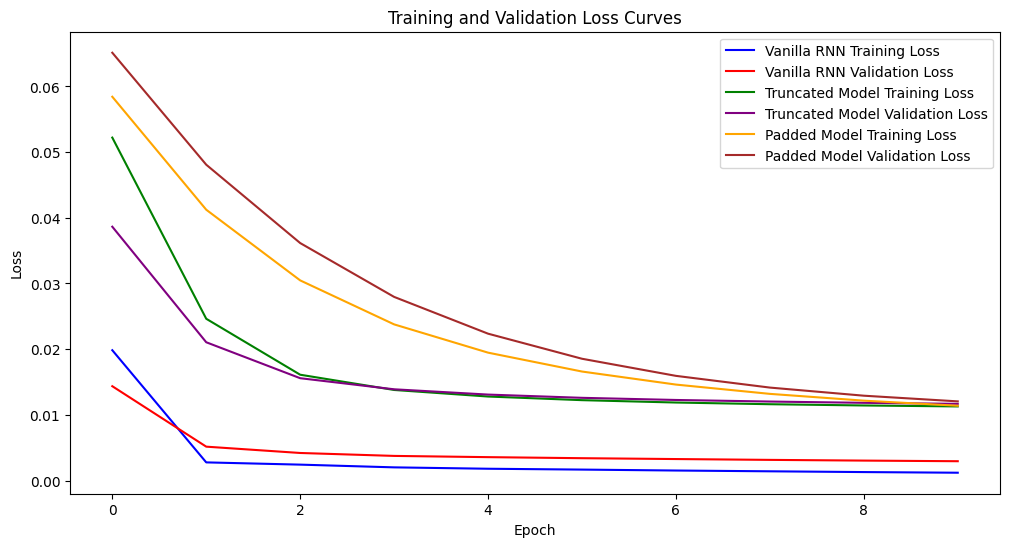

In [42]:
# Plot training and validation loss curves for each model
plt.figure(figsize=(12, 6))
plt.plot(range(num_epochs), train_losses_vanilla, label="Vanilla RNN Training Loss", color="blue")
plt.plot(range(num_epochs), val_losses_vanilla, label="Vanilla RNN Validation Loss", color="red")
plt.plot(range(num_epochs), train_losses_truncated, label="Truncated Model Training Loss", color="green")
plt.plot(range(num_epochs), val_losses_truncated, label="Truncated Model Validation Loss", color="purple")
plt.plot(range(num_epochs), train_losses_padded, label="Padded Model Training Loss", color="orange")
plt.plot(range(num_epochs), val_losses_padded, label="Padded Model Validation Loss", color="brown")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

**Vanilla Model:**
- *Advantages:* The Vanilla Model exhibits the lowest training and validation losses among the three models, indicating good convergence and predictive performance. Also, it shows rapid convergence, reaching a low validation loss by the second epoch.
- *Disadvantages:* The Vanilla Model may not handle sequences with varying lengths effectively as it relies on shared weights, which might not capture long-term dependencies in sequences with significant length variations. It has the potential to overfit when working with data with varying lengths, as it doesn't have mechanisms to handle padding or truncated sequences.

**Truncated Model:**
- *Advantages:* The Truncated Model effectively handles sequences with varying lengths by truncating them to a common length. It demonstrates reasonable convergence and predictive performance, with both training and validation losses decreasing over epochs.
- *Disadvantages:* Truncating sequences may result in information loss for longer sequences, potentially not capturing long-term dependencies effectively, especially for sequences with much longer original lengths. The training and validation losses, while decreasing, are relatively higher than the Vanilla Model, indicating room for improvement in performance.

**Padded Model:**
- *Advantages:* The Padded Model deals with sequences of varying lengths by padding them to a common length, preserving all information. It exhibits consistent convergence and predictive performance, with both training and validation losses decreasing significantly.
- *Disadvantages:* Padding can result in a considerable increase in input size, leading to higher computational requirements, which can be a drawback when working with large datasets. Training and validation losses, while decreasing, start at higher initial values compared to the other models, suggesting slower convergence.

### Problem 3

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {} # Map words to unique indices
        self.word2count = {} # Track word counts
        self.index2word = {0: "SOS", 1: "EOS"} # Initialize special tokens
        self.n_words = 2 # Count SOS and EOS

    # Add sentence to vocabulary
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    # Add word to vocabulary
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [4]:
# Convert Unicode to ASCII and remove diacritics
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, space punctuation, and remove non-alphanumeric characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [5]:
# Read language pairs, handle reverse order, and generate translation or autoencoder
def readLangs(lang1, lang2, reverse=False, autoencoder=False):
    print("Reading lines...")

    # Read lines from file and split into pairs
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Prepare pairs based on the autoencoder flag
    if autoencoder:
        pairs = [[normalizeString(l.split('\t')[0]), normalizeString(l.split('\t')[0])] for l in lines]
    else:
        pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Handle reverse order, create language instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10 # Maximum length for scentences

# Common English prefixes
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

# Common French phrases
fr_prefixes = (
    "je suis ", "j'suis ",
    "il est ", "il'st ",
    "elle est ", "elle'st ",
    "tu es ", "t'es ",
    "nous sommes ", "nous'sommes ",
    "ils sont ", "ils'sont "
)

# Filter pair based on length and prefixes, with autoencoder option
def filterPair(p, autoencoder=False):
    prefixes = eng_prefixes if autoencoder else fr_prefixes
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(prefixes)

# Filter pairs based on specified language type
def filterPairs(pairs, autoencoder=False):
    return [pair for pair in pairs if filterPair(pair, autoencoder)]

In [7]:
def prepareData(lang1, lang2, reverse=False, autoencoder=False):
    # Read language pairs and initialize language vocabularies
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse, autoencoder)
    print("Read %s sentence pairs" % len(pairs))

    # Filter pairs based on length and prefixes
    pairs = filterPairs(pairs, autoencoder)
    print("Trimmed to %s sentence pairs" % len(pairs))

    # Count words in vocabularies
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    # Display vocabulary sizes
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

# Prepare data for English to French translation
input_lang, output_lang, pairs = prepareData('eng', 'fra')
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 6391 sentence pairs
Counting words...
Counted words:
eng 2405
fra 3150
['i m here to save you', 'je suis la pour vous sauver']


In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True) # Define Gated Recurrent Unit (GRU) layer
        self.dropout = nn.Dropout(dropout_p) # Apply dropout to input during training for regularization

    def forward(self, input):
        embedded = self.dropout(self.embedding(input)) # Apply dropout to embedded input
        output, hidden = self.gru(embedded) # Pass embedded input through GRU layer
        return output, hidden

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True) # Define Gated Recurrent Unit (GRU) layer
        self.out = nn.Linear(hidden_size, output_size) # Define linear layer

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        # Loop over maximum sequence length
        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            # Determine next decoder input
            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        # Concatenate decoder outputs and apply log-softmax
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None

    def forward_step(self, input, hidden):
        output = self.embedding(input) # Apply embedding layer to input
        output = F.relu(output) # Apply ReLU activation
        output, hidden = self.gru(output, hidden) # Pass through GRU layer
        output = self.out(output) # Use linear layer for output
        return output, hidden

In [10]:
# Convert sentence to list of word indices
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# Convert sentence to tensor with End of Sequence (EOS) token
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

# Create input and target tensors from language pair
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Prepare dataloader for training
def get_dataloader(batch_size, autoencoder=False):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', autoencoder=autoencoder)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    # Convert language pairs to numerical tensors
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    # Create DataLoader for prepared data
    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [11]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        # Initialize gradients for encoder and decoder
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # Pass input through encoder then decode
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        # Calculate loss between decoder outputs and target
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        # Backpropagate and optimize encoder and decoder
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        total_loss += loss.item() # Accumulate loss for epoch

    return total_loss / len(dataloader)

In [12]:
# Convert seconds to human-readable time format
def asMinutes(s):
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# Calculate and format remaining time during training
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100):
    start = time.time()
    plot_losses = [] # Initialize list to track losses
    print_loss_total = 0 # Initialize variable to accumulate loss

    # Define optimizers for encoder and decoder and loss criterion
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    # Loop over specified number of epochs
    for epoch in range(1, n_epochs + 1):
        # Perform training epoch and compute loss
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss

        # Print and record average loss at specified intervals
        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg))

In [14]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        # Pass input through encoder then decode
        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1) # Get top predicted indices
        decoded_ids = topi.squeeze() # Squeeze output tensor

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>') # Append EOS if end token encountered
                break
            decoded_words.append(output_lang.index2word[idx.item()]) # Append corresponding word
    return decoded_words, decoder_attn

In [15]:
# Set hidden state and batch size
hidden_size = 128
batch_size = 32

# Create dataloader for training
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# Initialize encoder and decoder models
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train models for 80 epochs, printing loss every 5 epochs
train(train_dataloader, encoder, decoder, 80, print_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 6391 sentence pairs
Counting words...
Counted words:
eng 2405
fra 3150
0m 11s (- 2m 59s) (5 6%) 2.1795
0m 23s (- 2m 43s) (10 12%) 1.2595
0m 34s (- 2m 30s) (15 18%) 0.8512
0m 46s (- 2m 18s) (20 25%) 0.6030
0m 57s (- 2m 6s) (25 31%) 0.4414
1m 8s (- 1m 53s) (30 37%) 0.3331
1m 19s (- 1m 41s) (35 43%) 0.2588
1m 30s (- 1m 30s) (40 50%) 0.2081
1m 41s (- 1m 19s) (45 56%) 0.1723
1m 53s (- 1m 7s) (50 62%) 0.1481
2m 4s (- 0m 56s) (55 68%) 0.1296
2m 15s (- 0m 45s) (60 75%) 0.1181
2m 27s (- 0m 33s) (65 81%) 0.1101
2m 38s (- 0m 22s) (70 87%) 0.1016
2m 53s (- 0m 11s) (75 93%) 0.0981
3m 7s (- 0m 0s) (80 100%) 0.0939


In [16]:
# Set hidden state and batch size
hidden_size = 128
batch_size = 32

# Create dataloader for training autoencoder
input_lang, output_lang, train_dataloader = get_dataloader(batch_size, True)

# Initialize encoder and decoder models
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train models for 80 epochs, printing loss every 5 epochs
train(train_dataloader, encoder, decoder, 80, print_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 12109 sentence pairs
Counting words...
Counted words:
eng 3131
fra 3131
0m 21s (- 5m 21s) (5 6%) 1.6012
0m 42s (- 4m 55s) (10 12%) 0.6923
1m 3s (- 4m 36s) (15 18%) 0.3481
1m 26s (- 4m 20s) (20 25%) 0.1824
1m 48s (- 3m 58s) (25 31%) 0.0980
2m 10s (- 3m 37s) (30 37%) 0.0540
2m 31s (- 3m 14s) (35 43%) 0.0324
2m 56s (- 2m 56s) (40 50%) 0.0213
3m 18s (- 2m 34s) (45 56%) 0.0162
3m 40s (- 2m 12s) (50 62%) 0.0117
4m 1s (- 1m 49s) (55 68%) 0.0085
4m 22s (- 1m 27s) (60 75%) 0.0088
4m 44s (- 1m 5s) (65 81%) 0.0083
5m 7s (- 0m 43s) (70 87%) 0.0044
5m 28s (- 0m 21s) (75 93%) 0.0068
5m 50s (- 0m 0s) (80 100%) 0.0062


In [17]:
# Save state dictionary of encoder model to file
torch.save(encoder.state_dict(), 'autoencoder_encoder.pth')

# Create new encoder model and load saved state dictionary
loaded_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
loaded_encoder.load_state_dict(torch.load('autoencoder_encoder.pth'))

# Freeze parameters of loaded encoder
for param in loaded_encoder.parameters():
    param.requires_grad = False

In [18]:
# Set hidden state and batch size
hidden_size = 128
batch_size = 32

# Create dataloader for training
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

# Initialize new decoder model
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

# Train frozen encoder and new decoder for 80 epochs, printing loss every 5 epochs
train(train_dataloader, loaded_encoder, decoder, 80, print_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 6391 sentence pairs
Counting words...
Counted words:
eng 2405
fra 3150
0m 10s (- 2m 40s) (5 6%) 2.2230
0m 21s (- 2m 32s) (10 12%) 1.3586
0m 35s (- 2m 32s) (15 18%) 1.0289
0m 45s (- 2m 17s) (20 25%) 0.8307
0m 56s (- 2m 4s) (25 31%) 0.7004
1m 6s (- 1m 51s) (30 37%) 0.6083
1m 17s (- 1m 39s) (35 43%) 0.5412
1m 28s (- 1m 28s) (40 50%) 0.4896
1m 38s (- 1m 16s) (45 56%) 0.4484
1m 49s (- 1m 5s) (50 62%) 0.4166
1m 59s (- 0m 54s) (55 68%) 0.3874
2m 10s (- 0m 43s) (60 75%) 0.3643
2m 20s (- 0m 32s) (65 81%) 0.3444
2m 31s (- 0m 21s) (70 87%) 0.3279
2m 42s (- 0m 10s) (75 93%) 0.3129
2m 52s (- 0m 0s) (80 100%) 0.2998
